# Токсичные комментарии

Необходимо построить модель, которая будет классифицировать комментарии на позитивные и негативные. Даная модель нужна магазину с целью поиска токсичных комментариев и отправкой их на модерацию. Значение метрики качества *F1*  должно быть не меньше 0.75. 

In [2]:
!pip install spacy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached spacy-2.3.0-cp37-cp37m-manylinux1_x86_64.whl (10.0 MB)
  Using cached blis-0.4.1-cp37-cp37m-manylinux1_x86_64.whl (3.7 MB)
  Using cached thinc-7.4.1-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)


In [3]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 35.3 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.0-py3-none-any.whl size=12048607 sha256=282bf719961ef801c9b0b29c4cc6d6e0dc9cc0889628cf15a67dd730718291eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-n3sn0_kk/wheels/71/4a/56/e48f8ad9359a6780edd8cdd42955519b1a21d6365ad15628a2
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


#### Библиотеки и модули

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Содержание

1. Подготовка  
    - Токенизация и лемматизация  
    - Bag of Words  
    - TF-IDF  
2. Обучение  
    - Дисбаланс классов
    - Logistic Regression
3. Вывод

## Подготовка

In [5]:
path = '/datasets/toxic_comments.csv'

In [6]:
comments = pd.read_csv(path)
comments.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
comments.isnull().sum()

text     0
toxic    0
dtype: int64

In [8]:
X = comments['text'].to_numpy()
y = comments['toxic'].to_numpy()

In [9]:
del comments

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [11]:
X_train[:3]

array(["Ad hominem doesn't mean name calling, he subhuman racist slime.  —",
       ') 09:51, 24 December 2011 (UTC',
       '"\n\nEditing for style\nIn ""A simplified example,"" I found having the reference to Newton\'s Second Law at the beginning of the sentence interrupted the description of what was happening to movement of the charged particles, so I moved it to the end of the sentence and added the equation, F = ma.   "'],
      dtype=object)

### Токенизация и лемматизация

In [12]:
# tokenizer = WordPunctTokenizer()
# lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en', disable=['parser', 'ner'])

In [13]:
def clear(text):
    return ' '.join(re.sub(r"[^A-Za-z' ]", ' ', text).split())

def tokenize(text):
    # return tokenizer.tokenize(text.lower())
    return nlp(text)

def lemmatize(text):
    # return ''.join(lemmatizer.lemmatize(text.lower()))
    return text.lemma_

def tokenize_lemmatize_X(X):
    for i in range(X.shape[0]):
        cleared_X = clear(X[i])
        tokenized_X = tokenize(cleared_X)
        lemmatized_X = ' '.join([lemmatize(token) for token in tokenized_X])
        X[i] = lemmatized_X
    return X

In [14]:
X_train_new = tokenize_lemmatize_X(X_train)
X_test_new = tokenize_lemmatize_X(X_test)

In [15]:
X_train[:3]

array(['ad hominem do not mean name call -PRON- subhuman racist slime',
       'December UTC',
       "edit for style in a simplified example -PRON- find have the reference to Newton 's Second Law at the beginning of the sentence interrupt the description of what be happen to movement of the charge particle so -PRON- move -PRON- to the end of the sentence and add the equation F ma"],
      dtype=object)

### Bag of Words

Создадим мешок слов с исключением стоп-слов и добавлением n-грамм.

In [16]:
stop_words = set(stopwords.words('english'))

In [17]:
count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(1, 1)) # рассматриваю биграммы
X_train_bow = count_vect.fit_transform(X_train)

In [18]:
X_test_bow = count_vect.transform(X_test)

### TF-IDF

Аналогично при использовании подхода TF-IDF исключим стоп-слова и добавим n-граммы.

In [19]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
X_train_tfidf = tfidf_vect.fit_transform(X_train)

In [20]:
X_test_tfidf = tfidf_vect.transform(X_test)

## Обучение

Для обучения используем такую модель как Logistic Regression.

### Дисбаланс классов

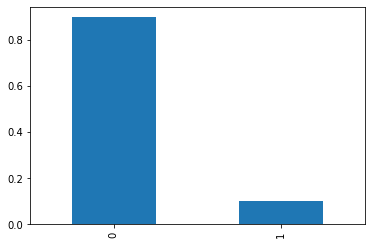

In [23]:
class_frequency = pd.Series(y_train).value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.show()

In [24]:
y_train.shape

(127656,)

Видим значительный дисбаланс классов в обучающей выборке. Для решения проблемы дисбаланса воспользуемся взвешиванием классов.

### Logistic Regression

In [26]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=7)
lr.fit(X_train_bow, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_pred_lr = lr.predict(X_test_bow)

In [28]:
print(f'Значение мтерики F1 при использовании логистической регрессии и мешка слов: {f1_score(y_test, y_pred_lr)}')

Значение мтерики F1 при использовании логистической регрессии и мешка слов: 0.7544812601846823


In [29]:
lr_tfidf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=7)
lr_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

In [31]:
print(f'Значение мтерики F1 при использовании логистической регрессии и TF-IDF: {f1_score(y_test, y_pred_lr_tfidf)}')

Значение мтерики F1 при использовании логистической регрессии и TF-IDF: 0.7473809839543827


## Вывод

Достигили поставленной цели: метрика F1 на логистической регрессии при использовании мешка слов со взвешиванием классов составила 0.7544.